In [1]:
import sys
if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

# Improving Transient Response via Cascade Compensation with Root-Locus Design
---

In [2]:
%matplotlib inline

In [3]:
from python_control import s, TransferFunction, get_damping_ratio, RootLocus
from python_control.design.root_locus import (
    design_P_feedback,
    design_PD_feedback,
    design_lead_feedback
)
from python_control.design import create_second_order_system, plot_step_responses

## Plant Transfer Function

Transfer function of the plant to be controlled by a (negative) feedback system.

In [4]:
G_p = TransferFunction(1 / (s * (s + 4) * (s + 6)))

## Transient Response Requirements

The desired percent overshoot of the unity-feedback system is specified. This can be translated into a required value for the damping ratio (assuming the feedback system can be approximated as a second-order system).

In [5]:
percent_overshoot = 30
zeta = get_damping_ratio(percent_overshoot)
print(zeta)

0.3578571305033167


## Design of Uncompensated Unity-Feedback System

Determine the required forward gain of the unity-feedback system so that the required damping ratio would be attained.

In [6]:
design_uc = design_P_feedback(
    G_plant=G_p, 
    damping_ratio=zeta,
    name='uncompensated'
)

In [7]:
print(design_uc.forward_gain)

63.22775812820211


This is the overall forward-path gain, which is also the open-loop gain in a unity-feedback system. As the plant gain is 1, the overall forward-path gain is the gain provided by a P-controller added in series to the plant.

The root locus of the uncompensated feedback system (the root locus is the solution set for the closed-loop poles of the feedback system that still depend on the actual open-loop gain of the feedback system). In the figure below, the black square dots indicate the locations of the closed-loop poles of the feedback system at the calculated forward gain.

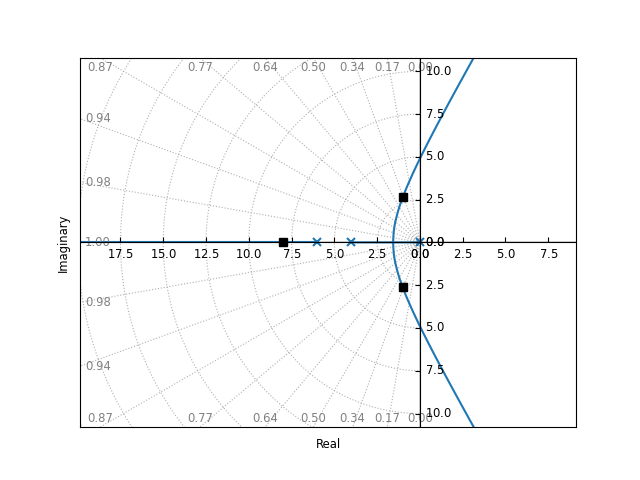

In [9]:
root_locus1 = RootLocus(G_p)
root_locus1.plot(dynamic=True, initial_gain=design_uc.forward_gain)

In [10]:
for pole in design_uc.feedback_system.closed_loop.poles: print(pole)

(-7.986162142315871+0j)
(-1.0069189288420677+2.6274091061233715j)
(-1.0069189288420677-2.6274091061233715j)


Transient response and steady-state error characteristics of the feedback system.

In [11]:
print(design_uc.characteristics)

system type: type_1
steady-state error: 0.38
static error constant: 2.63
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 2.81
damping ratio: 0.358
rise time: 0.54
peak time: 1.34
settling time: 4.01
percent overshoot: 28


We can compare the unit-step response of the feedback system with the unit-step response of its second-order approximation. For this, we first create the second-order system using the dominant pole pair of the feedback system (this is the complex closed-loop pole pair closest to the imaginary axis that has the most influence on the duration of the transient response or settling time).   

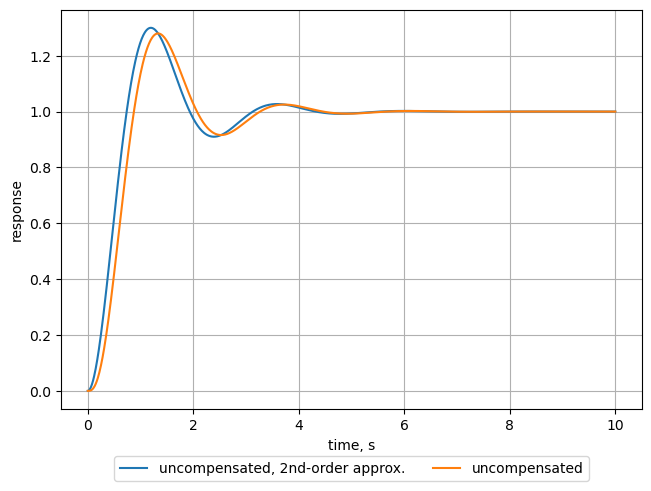

In [12]:
sosys_uc = create_second_order_system(
    dominant_pole=design_uc.feedback_system.dominant_pole_pair[0],
    name='uncompensated, 2nd-order approx.'
) 

plot_step_responses(design_uc.feedback_system, sosys_uc)

## Design of Compensated Unity-Feedback System

Suppose we want to reduce the settling time by a factor of two.

### With PD-Controller

In [13]:
design_pd = design_PD_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    name='PD-feedback'
)

[10920 | python_control.design.root_locus | DEBUG] dominant pole: (-1.9963208340131138+5.209110076082758j)
[10920 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 127.61612091881878
[10920 | python_control.design.root_locus | DEBUG] compensator zero: -6.010211009455968
[10920 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 52.383879081181206
[10920 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 179.99999999999997


The transient response requirements (settling time and damping ratio) determine the location of a dominant pole pair in the complex $s$-plane. The zero added by the PD-controller should modify the root locus of the feedback system such that the root locus goes through this dominant poles (this may not always be possible).

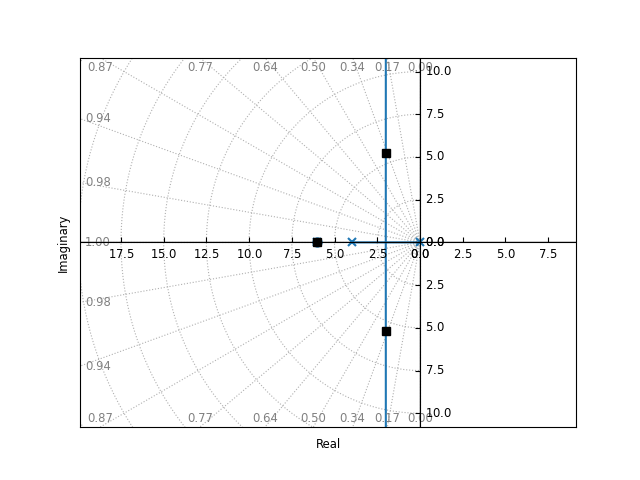

In [14]:
root_locus2 = RootLocus(design_pd.feedback_system.open_loop)
root_locus2.plot(dynamic=True, initial_gain=design_pd.forward_gain)

In [15]:
for pole in design_pd.feedback_system.closed_loop.poles: print(pole)

(-6.00735833197376+0j)
(-1.996320834013115+5.2091100760827596j)
(-1.996320834013115-5.2091100760827596j)


In [16]:
print(design_pd.feedback_system.dominant_pole_pair)

((-1.996320834013115+5.2091100760827596j), (-1.996320834013115-5.2091100760827596j))


We see from the debug log messages that the dominant pole that was determined by the function `design_PD_feedback` to meet the transient response requirements, matches with the final dominant pole pair of the PD-controlled feedback system.

The required overall forward-path gain (open-loop gain of the unity-feedback system) that needs to be provided by the PD-controller (as the plant gain is 1) is now:

In [17]:
print(design_pd.forward_gain)

31.105353848064752


A PD-controller can be regarded as a separate P-controller and D-controller connected in parallel (the P- and D-control actions are added).

In [18]:
design_pd.controller.expr

31.1053538480648*s + 186.949740150662

The gain of the P-action and the gain of the D-action can be retrieved with:

In [19]:
print(design_pd.controller_gains.K_p, design_pd.controller_gains.K_d)

186.949740150662 31.1053538480648


The zero added to the open-loop transfer function of the feedback system is:

In [20]:
print(design_pd.controller.zeros)

[-6.01021101+0.j]


Transient response and steady-state error characteristics of the feedback system:

In [21]:
print(design_pd.characteristics)

system type: type_1
steady-state error: 0.128
static error constant: 7.79
steady-state value: 1
dc-gain: 1
second-order approximation: True
natural frequency: 5.58
damping ratio: 0.358
rise time: 0.251
peak time: 0.609
settling time: 2.07
percent overshoot: 30


Comparison between the unit-step response of the uncompensated feedback system and the unit-step response of the PD-controlled feedback system.

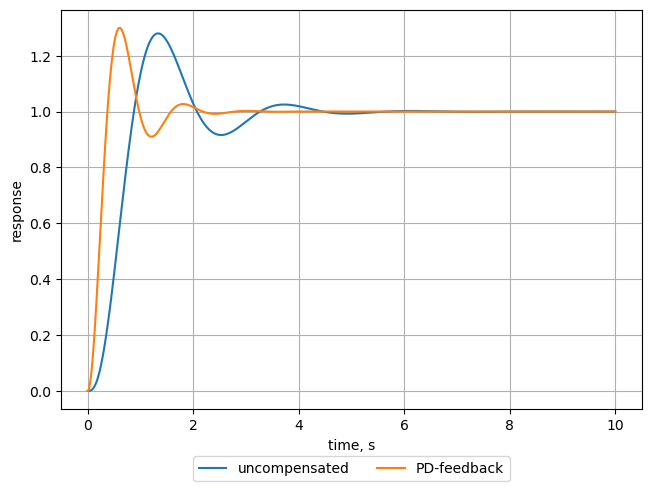

In [22]:
plot_step_responses(design_uc.feedback_system, design_pd.feedback_system)

### With Lead Compensator

In case of a lead compensator, we need to select the zero of the compensator ourselves. The function `design_lead_feedback` calculates the location of the compensator pole such that the root locus of the feedback system would go through the dominant pole that follows from the transient response requirements.

In [23]:
design_lead = design_lead_feedback(
    settling_time=design_uc.characteristics.settling_time / 2,
    peak_time=None,
    damping_ratio=zeta,
    G_plant=G_p,
    compensator_zero=-2,
    name='lead compensation'
)

[10920 | python_control.design.root_locus | DEBUG] dominant pole: (-1.9963208340131138+5.209110076082758j)
[10920 | python_control.design.root_locus | DEBUG] open-loop transfer function angle before compensation: 127.61612091881878
[10920 | python_control.design.root_locus | DEBUG] LEAD compensator zero: -2, pole: -8.766437291460736
[10920 | python_control.design.root_locus | DEBUG] angular contribution of compensator zero: 89.95953231069319
[10920 | python_control.design.root_locus | DEBUG] angular contribution of compensator pole: 37.57565322951199
[10920 | python_control.design.root_locus | DEBUG] open-loop transfer function angle after compensation: 180.0


Root locus.

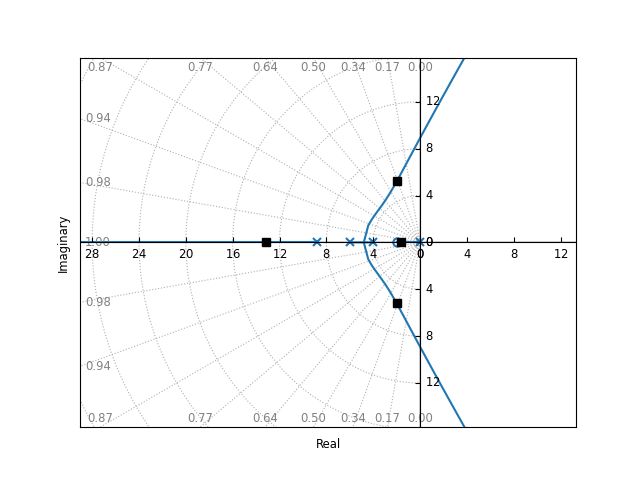

In [24]:
root_locus3 = RootLocus(design_lead.feedback_system.open_loop)
root_locus3.plot(dynamic=True, initial_gain=design_lead.forward_gain)

In [25]:
for pole in design_lead.feedback_system.closed_loop.poles: print(pole)

(-13.132198763298087+0j)
(-1.996320834013119+5.209110076082753j)
(-1.996320834013119-5.209110076082753j)
(-1.6415968601364221+0j)


In [26]:
print(design_lead.feedback_system.dominant_pole_pair[0])

(-1.996320834013119+5.209110076082753j)


Lead compensator.

In [27]:
print(design_lead.forward_gain)

335.44034221593546


In [28]:
design_lead.controller.expr

(335.440342215935*s + 670.880684431871)/(1.0*s + 8.76643729146074)

In [29]:
design_lead.controller.zeros

array([-2.+0.j])

In [30]:
design_lead.controller.poles

[(-8.76643729146074+0j)]

Transient response and steady-state error characteristics of the lead-compensated feedback system.

In [31]:
print(design_lead.characteristics)

system type: type_1
steady-state error: 0.314
static error constant: 3.19
steady-state value: 1
dc-gain: 1
second-order approximation: False
rise time: 0.325
peak time: 0.722
settling time: 1.73
percent overshoot: 14.3


Comparison between the unit-step responses of the uncompensated feedback system, the PD-controlled feedback system, and the lead-compensated feedback system.

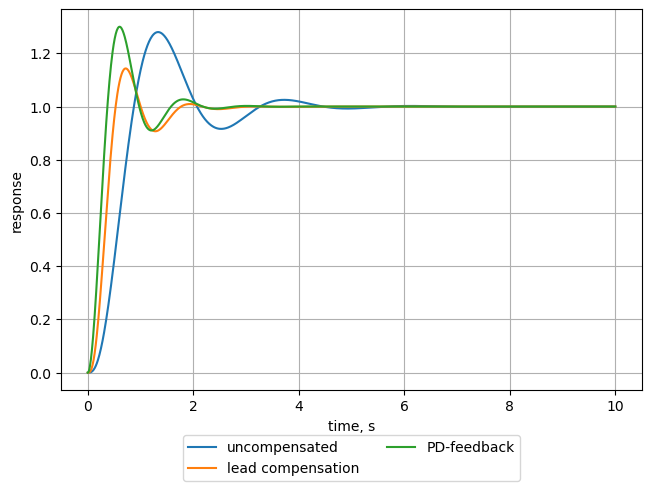

In [32]:
plot_step_responses(
    design_uc.feedback_system, 
    design_lead.feedback_system,
    design_pd.feedback_system
)